# 1. Loading and Cleaning

## 1.1 Import libraries and python files

In [54]:
#import useful libraries 
import json
import sys
import requests
import calendar
import scipy
import json
from IPython.display import display, HTML


import numpy as np
import pandas as pd
import statsmodels.api as sm
import ipywidgets as widgets
from IPython.display import display


import pandas as pd
import numpy as np
import statsmodels.api as sm 
import statsmodels.formula.api as smf
import seaborn as sbn
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from matplotlib.colors import LogNorm, Normalize
from sklearn.preprocessing import normalize
from datetime import datetime
%matplotlib inline 

# Import functions helper and loading functions
from data_loader import *
from helper_functions import *
%load_ext autoreload
%autoreload 2


##link to the datasets
## https://www.cs.cmu.edu/~ark/personas/
##https://www.kaggle.com/datasets/rounakbanik/the-movies-dataset?resource=download&select=movies_metadata.csv
##https://www.kaggle.com/datasets/ashirwadsangwan/imdb-dataset

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 1.2 Load the different datasets

In [55]:
##load datasets from CMU dataset
df_character = load_character().copy()
df_movie = load_movie().copy()
df_name_cluster = load_name_cluster().copy()
df_summary = load_plot_summary().copy()
df_tropes_cluster = load_tropes_cluster().copy()

In [56]:
# Replace 'id-translation.wikidata.json' with the path to your JSON file
file_path = 'id-translation.wikidata.json'

# Load the JSON file into a DataFrame
df_id_translation = pd.read_json(file_path, orient='records', lines=True)

In [57]:
# Small cleanup
df_id_translation = df_id_translation.dropna(subset=['Freebase ID'])
df_id_translation.drop_duplicates(subset=['Freebase ID'], keep='first', inplace=True)

In [58]:
# df_movie will be the reference dataframe. After being completed with additional datasets, it must never be modified
df_movie = pd.merge(df_movie, df_id_translation, on='Freebase ID', how='left')

In [59]:
#compute percentage of missing values for df_movie
values = ['Year', 'Month', 'Box office', 'Runtime', 'tconst']

def compute_missing_values(df, values):
    for variable in values :
        percentage_missing_values = (df[variable].isna().sum()/len(df[variable]))*100
        print(f"The percentage of missing values in {variable} is {format(percentage_missing_values, '.3f')}%.")

    
compute_missing_values(df_movie, values)

The percentage of missing values in Year is 8.444%.
The percentage of missing values in Month is 51.832%.
The percentage of missing values in Box office is 89.722%.
The percentage of missing values in Runtime is 25.018%.
The percentage of missing values in tconst is 9.769%.


As we can see, a lot of 'Box office' data is missing. We should add some other database to try to reduce the missing data.

## 1.3 Load addtionnal datasets and merge what we need 

In [60]:
#load imdb dataset (from kaggle)
df_imdb_movie = load_movie_imdb_kaggle()
df_imdb_rating = load_rating_imdb_kaggle() 

#merge movies with rating 
df_movie_rating = pd.merge(df_imdb_movie, df_imdb_rating, on='tconst', how='inner')

In [61]:
#merge CMU dataset with IMDB dataset
df_movie = pd.merge(df_movie, df_movie_rating[['tconst', 'averageRating', 'numVotes']], on=['tconst'], how='left')
#display(df_movie)

In [62]:
# missing Rating values
values = ['averageRating', 'numVotes']

compute_missing_values(df_movie, values)
print(f"The number of movies with missing values for 'averageRating' and 'numVotes' is {df_movie['averageRating'].isna().sum()}.")

The percentage of missing values in averageRating is 31.271%.
The percentage of missing values in numVotes is 31.271%.
The number of movies with missing values for 'averageRating' and 'numVotes' is 25561.


In [63]:
## load kaggle movie metadata
df_kaggle_movie = load_movie_kaggle()

In [64]:
#merge the datasets on the 'Name' column
#df_movie = df_movie.merge(df_kaggle_movie[['Name', 'Year', 'Month', 'Day']], on=['Name', 'Year'], how='left', suffixes=('', '_df2'))
df_movie = df_movie.merge(df_kaggle_movie[['Name', 'Year', 'tconst', 'Month', 'Day']], on=['Name', 'Year','tconst'], how='left', suffixes=('', '_df2'))

In [65]:
#use 'combine_first' to fill in the 'Box office' values from df_kaggle_movie where they are NaN in df_movie
df_movie['Month'] = df_movie['Month'].combine_first(df_movie['Month_df2'])
df_movie['Day'] = df_movie['Day'].combine_first(df_movie['Day_df2'])

#drop the extra 'Box office' column from df_kaggle_movie
df_movie.drop('Month_df2', axis=1, inplace=True)
df_movie.drop('Day_df2', axis=1, inplace=True)

In [66]:
values = ['Year', 'Month', 'Box office', 'Runtime', 'tconst']
compute_missing_values(df_movie, values)

The percentage of missing values in Year is 8.442%.
The percentage of missing values in Month is 42.891%.
The percentage of missing values in Box office is 89.721%.
The percentage of missing values in Runtime is 25.014%.
The percentage of missing values in tconst is 9.767%.


In [67]:
#load oscar reward dataset
df_oscar = load_oscar_winner()

In [68]:
#filter the dataframe to only include rows where 'winner' is True
df_winner_movie = df_oscar[df_oscar['winner'] == True]

#group by the movie name and count the winners time
df_winner_movie = df_winner_movie.groupby('Name').agg(
    num_oscars_won=pd.NamedAgg(column='winner', aggfunc='size'),
    years_won=pd.NamedAgg(column='year_ceremony', aggfunc=lambda x: list(x))
).reset_index()

#sort the movies by oscars won
df_oscar_wins = df_winner_movie.sort_values(by='num_oscars_won', ascending=False)

In [69]:
#merge CUM and oscars awards dataset
df_movie = pd.merge(df_movie, df_oscar_wins, left_on='Name', right_on='Name', how='left')

#replace NaN values in 'num_oscars_won' with 0 for movies that didn't win any oscars
df_movie['num_oscars_won'].fillna(0, inplace=True)

In [70]:
percentage_oascar_movies = ((df_movie['num_oscars_won']!=0).sum()/len(df_movie['num_oscars_won']))*100
print(f"The percentage of movies having won an oscar is {format(percentage_oascar_movies, '.3f')}%.")

The percentage of movies having won an oscar is 1.896%.


## 1.4 Cleanup of the data

In [71]:
# Drop the row with 'Year' smaller than 1800 as we have seen somme erronous movie before and there is too few movies after 2014.
df_movie = df_movie[(df_movie['Year'] >= 1800) & (df_movie['Year'] <= 2013)]

# 2. Visualisation functions

As a first step, we visualize our data. This will give us insights about what to look for.

In [72]:
df_time_stamps = get_time_stamps_df(df_movie)

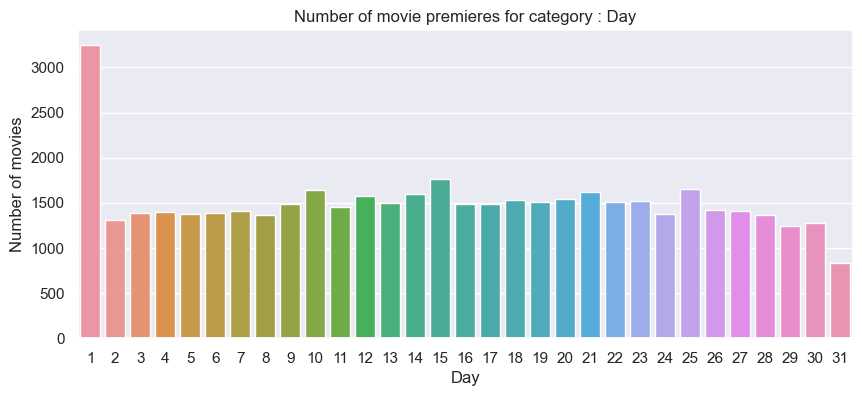

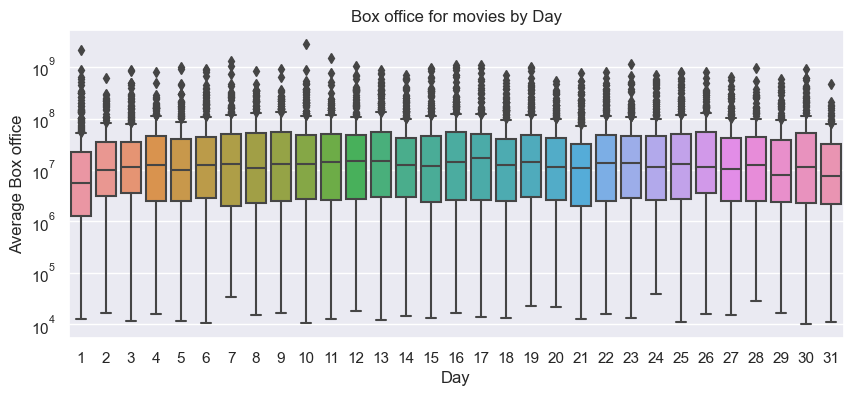

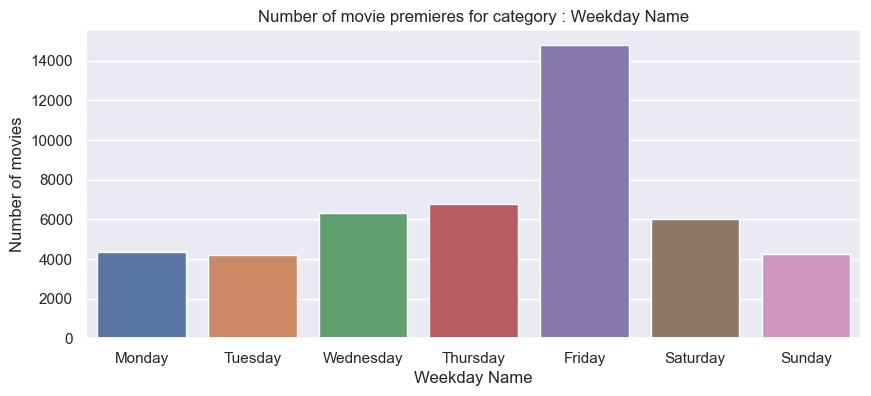

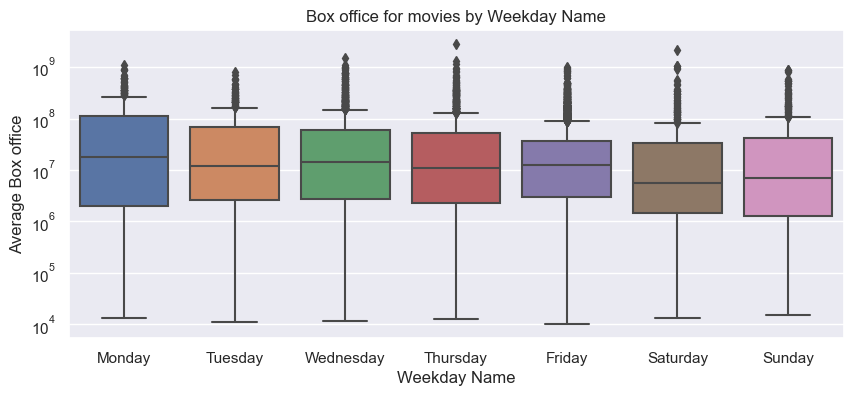

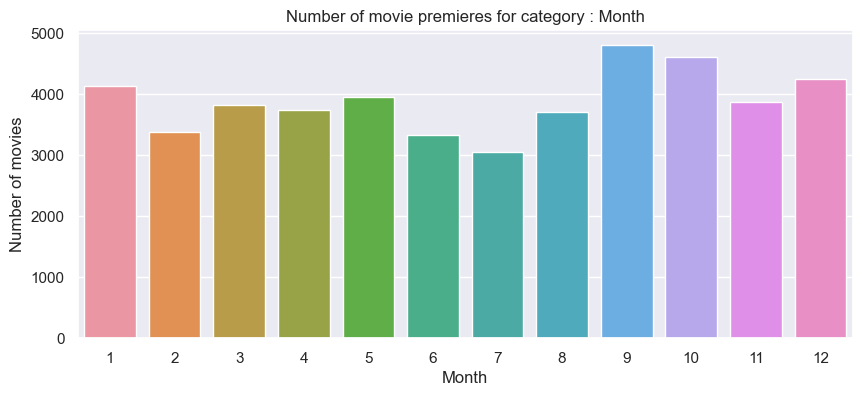

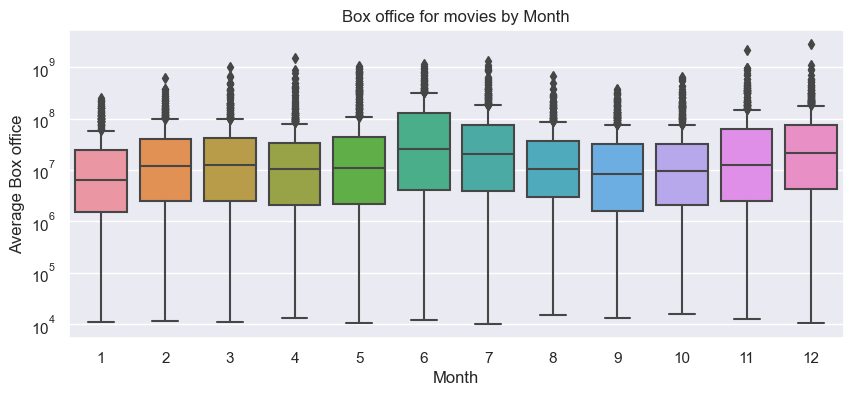

In [73]:
count_var(df_time_stamps, 'Day', show_chisquare=False)
avg_var(df_time_stamps, 'Box office', 'Day', logscale=True)

count_var(df_time_stamps, 'Weekday Name', show_chisquare=False)
avg_var(df_time_stamps, 'Box office', 'Weekday Name', logscale=True)

count_var(df_time_stamps, 'Month', show_chisquare=False)
a = avg_var(df_time_stamps, 'Box office', 'Month', logscale=True)


As we can see on the graph, the first day of the month is by far the most popular day to release movies. However, the first day of the month is also the worst median performer when it comes to box office success. This trend is also present for the day of the week, where the best day for box office seems to be Monday (based on median), even though Monday is not a typical day for movie releases. With those observations, we hypothesize that the most popular release day (week day or month day) is often a bad box office performer. 

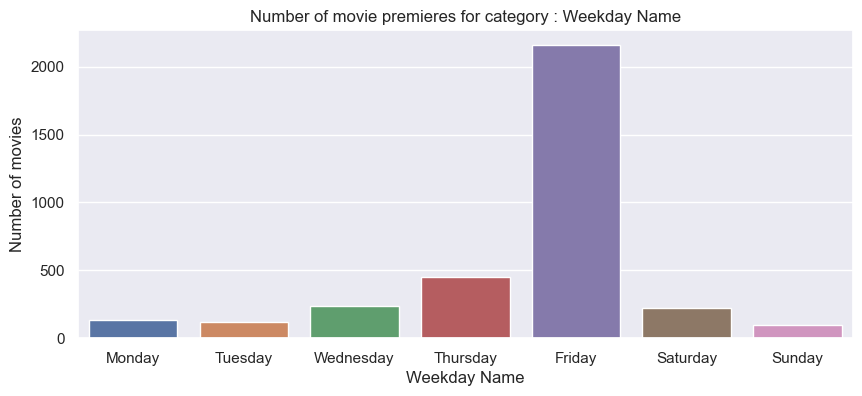

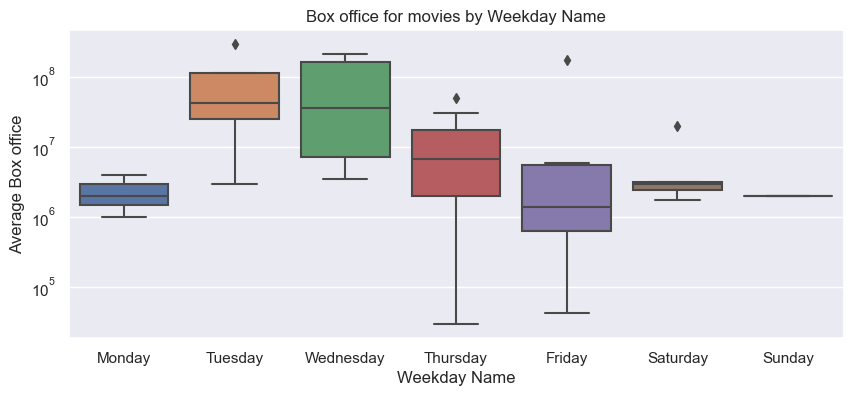

In [74]:
df_india = get_movies_country(df_time_stamps, 'India', contains=True)

count_var(df_india, 'Weekday Name', show_chisquare=False)
a = avg_var(df_india, 'Box office', 'Weekday Name', logscale=True)

If we look at the example of India, we can see that this effect is even more staggering. Friday has about two thirds of movie release, and the worst median for box office. Those observations (and many more that we won't show here to remain brief), give us confidence that there are trends based on the release dates that merit further investigation. 

# 3. Analysis of the release date based on the genre

## 3.1 Initial research
We need first to see how many genres are in the dataset and the number of movie of the given genre.

In [75]:
# How many movies of each genre ? 
df_genre_list = df_time_stamps.copy(deep=True)
genres = get_genres(df_genre_list)

print(f'There are {len(genres)} genres')
print(genres)

There are 355 genres
{'Thriller': 6237, 'Science Fiction': 2131, 'Horror': 3332, 'Adventure': 3413, 'Supernatural': 480, 'Action': 5777, 'Space western': 13, 'Mystery': 2305, 'Biographical film': 845, 'Drama': 21187, 'Crime Drama': 415, 'Short Film': 4429, 'Silent film': 3723, 'Indie': 4975, 'Black-and-white': 6544, 'Comedy': 11330, 'Musical': 2475, 'Romantic comedy': 2120, 'Ensemble Film': 372, 'Comedy-drama': 1339, 'Romantic drama': 2455, 'Romance Film': 7021, 'Costume drama': 420, 'War film': 1758, 'Epic': 229, 'Period piece': 1468, 'Film adaptation': 1311, "Children's/Family": 713, 'Fantasy': 1977, 'Family Film': 3139, "Children's Fantasy": 223, 'Future noir': 30, 'Erotic thriller': 144, 'Crime Fiction': 4719, 'Coming of age': 748, 'Marriage Drama': 150, 'World cinema': 4489, 'Western': 1577, 'Black comedy': 818, 'Action/Adventure': 3390, 'Cult': 623, 'Adventure Comedy': 127, 'Slapstick': 537, 'Biopic [feature]': 482, 'Historical Epic': 77, 'Political drama': 595, 'Historical ficti

## 3.2 Genre based on their profits

As seen above we have a total of 355 genres. Let's look more closely to the 20 more represented one, and if their ranking can represent how much these genres can be profitable.

In [76]:
# Sort the genres
sorted_genres = sorted(genres.items(), key=lambda x:x[1], reverse=True)
df_movie_genre = df_time_stamps.copy(deep=True)

# As we analyse the box office revenues, we need to clean it
df_movie_genre.dropna(subset=['Box office'], inplace=True)


n_genre = 20

#Get the n_genre genres and the average revenue of their movie
list_genres = list(dict(sorted_genres).keys())[0:n_genre]
for i in range(10):
    boxoffice_mean = df_movie_genre[df_movie_genre['genres (Freebase ID:name tuples)']
                       .str.contains(sorted_genres[i][0])==True]['Box office'].mean()
    print(f'Average box office for {sorted_genres[i][0]} : {int(boxoffice_mean):,}, which represents {sorted_genres[i][1]:,} movies')

Average box office for Drama : 41,711,679, which represents 21,187 movies
Average box office for Comedy : 52,215,997, which represents 11,330 movies
Average box office for Romance Film : 45,809,834, which represents 7,021 movies
Average box office for Black-and-white : 6,236,742, which represents 6,544 movies
Average box office for Thriller : 71,745,214, which represents 6,237 movies
Average box office for Action : 89,187,861, which represents 5,777 movies
Average box office for Indie : 14,393,350, which represents 4,975 movies
Average box office for Crime Fiction : 51,635,503, which represents 4,719 movies
Average box office for World cinema : 20,251,801, which represents 4,489 movies
Average box office for Short Film : 31,881,762, which represents 4,429 movies


With initial analysis, it seems that having a great number of movie does not mean the movie will be profitable based on the genre. It could be analysed further to check when some genre where more popular (and take in count the inflation as, for exemple, Black-and-white movie where more present tens of years ago, where the money had another value) to recheck if this hypothesis is true. 

However, for the initial analysis, let's look in another areas. As we want to see more relations of the time and the genres. For example, let's see if these 20 more present genre has a defined day of week for the release (and maybe see if the box office of the genre can be defined based on the days of the week too)

In [77]:
df_genre_list = []
# Explode the dataset for the n_genre most present genres
for i in range(n_genre):
    temp_df = df_time_stamps[df_time_stamps['genres (Freebase ID:name tuples)']
                             .str.contains(sorted_genres[i][0])==True].copy(deep=True)
    temp_df['Genre'] = sorted_genres[i][0]
    df_genre_list.append(temp_df)

df_movie_genre = pd.concat(df_genre_list)
#Remove any movie who does not have a genre in the n_genre most present
df_movie_genre.dropna(subset=['Genre'], inplace=True)

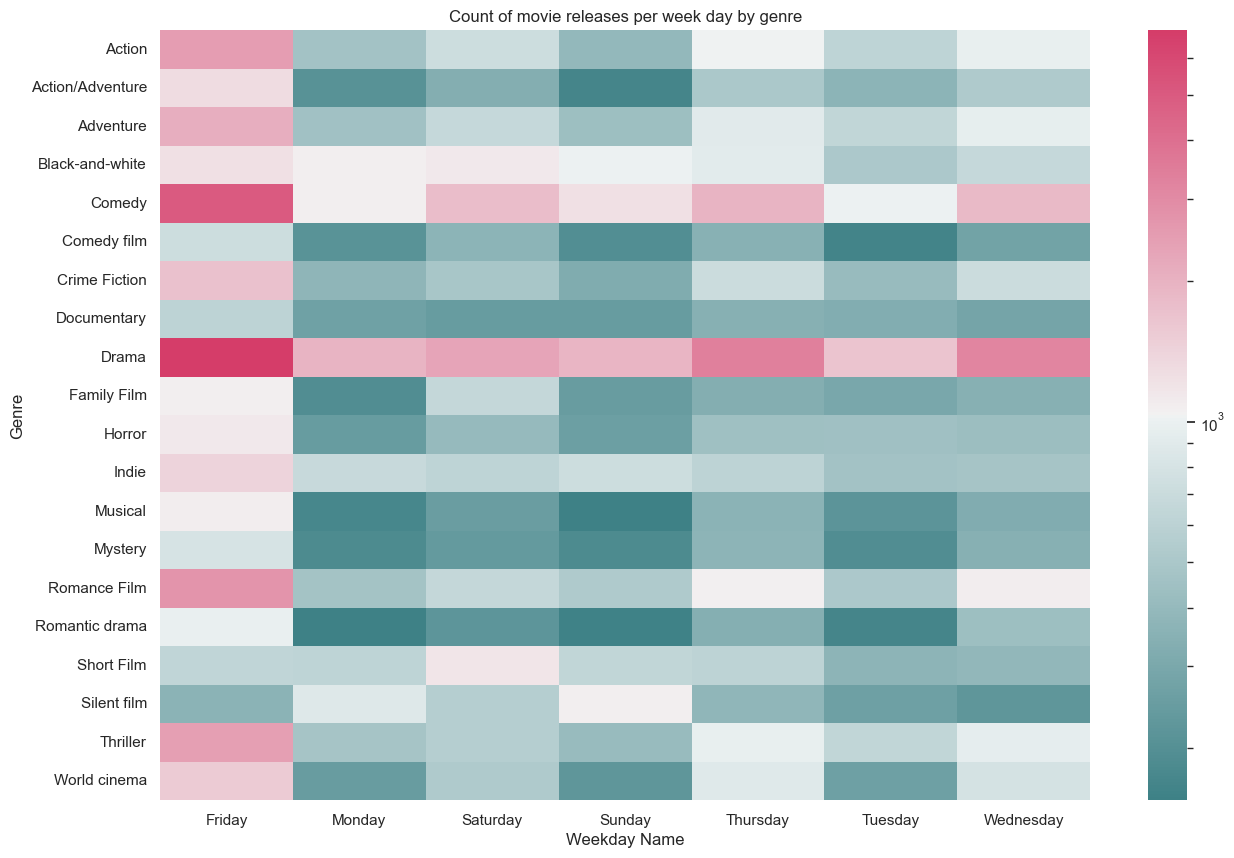

In [78]:
df_genre_weekday = pd.crosstab(df_movie_genre['Genre'],df_movie_genre['Weekday Name'])
plt.subplots(figsize=(15, 10))
sbn.heatmap(df_genre_weekday, annot=False, cmap=sbn.diverging_palette(200, 0, as_cmap=True), norm=LogNorm())
plt.title('Count of movie releases per week day by genre')
plt.show()

Without a big surprise, most of the great genre movies are released before or during the weekend, supposedly because it is the days where the most of people have free time and want to see a movie. But does this strategy work with the revenues of the movies ?

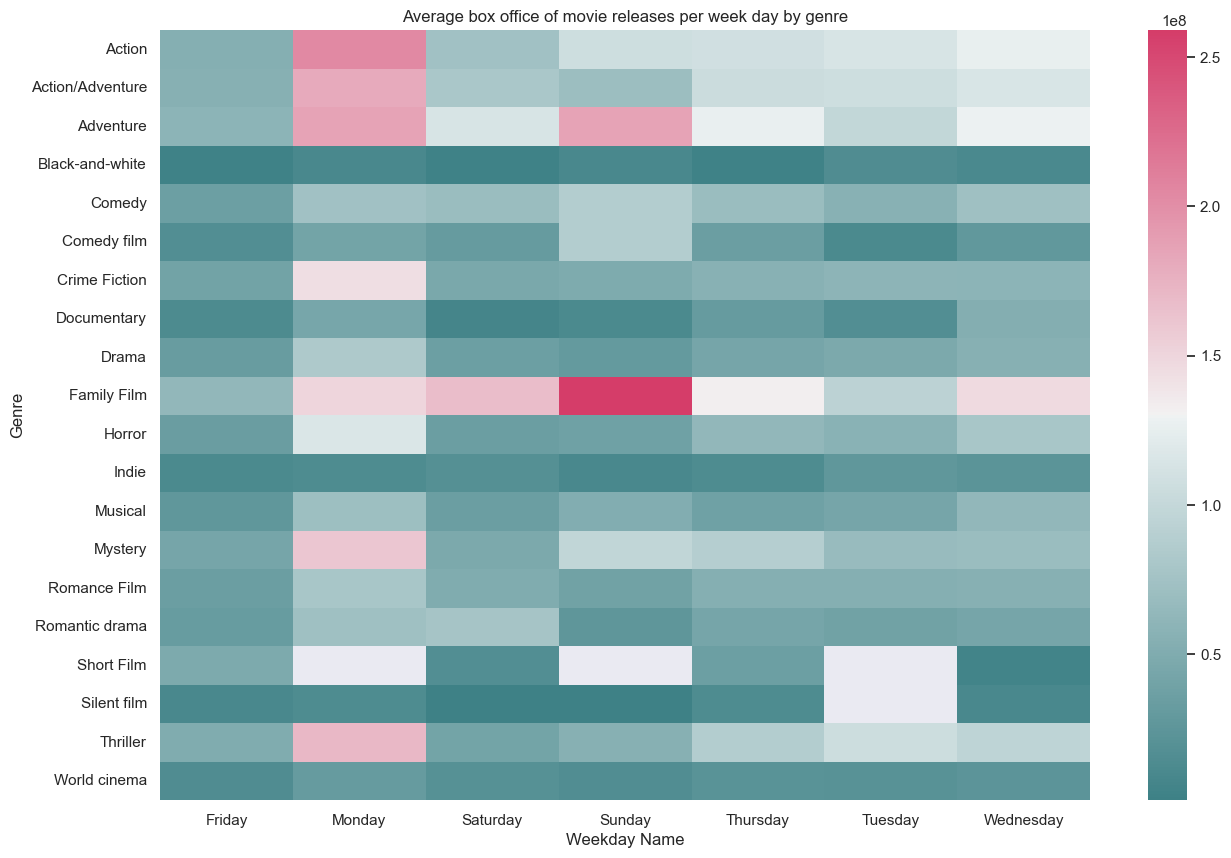

In [79]:
df_movie_genre_boxoffice = df_movie_genre.copy(deep=True)
df_movie_genre_boxoffice.dropna(subset=['Box office'], inplace=True)

df_genre_boxoffice = pd.crosstab(df_movie_genre_boxoffice['Genre'],df_movie_genre_boxoffice['Weekday Name'],
                  values=df_movie_genre_boxoffice['Box office'],aggfunc='mean')

plt.subplots(figsize=(15, 10))
sbn.heatmap(df_genre_boxoffice, annot=False, cmap=sbn.diverging_palette(200, 0, as_cmap=True))
plt.title('Average box office of movie releases per week day by genre')
plt.show()

We can clearly see in the previous heatmap that it is not the case. There is more revenues on monday movies, with another peak for Family Film and Adventure genre on sunday. The drop of revenue Friday could be explained with the number of movie released, as they 'fight' each other for the viewvers present on this day. For the peak of family film, Sunday is generally the day where children and adults have a day off, and is the perfect day to do something together.

## 3.3 Genre based fully on their relase date

We have seen on the previous section that the day of the release, for some of genre, show a varied Box Office revenue. Let's go further, removing the revenue of our analysis, to see if some month are better for some genre than other. As some genre have a greater number of movie, we have decided to normalize the data here to see more clearly the 'good months'

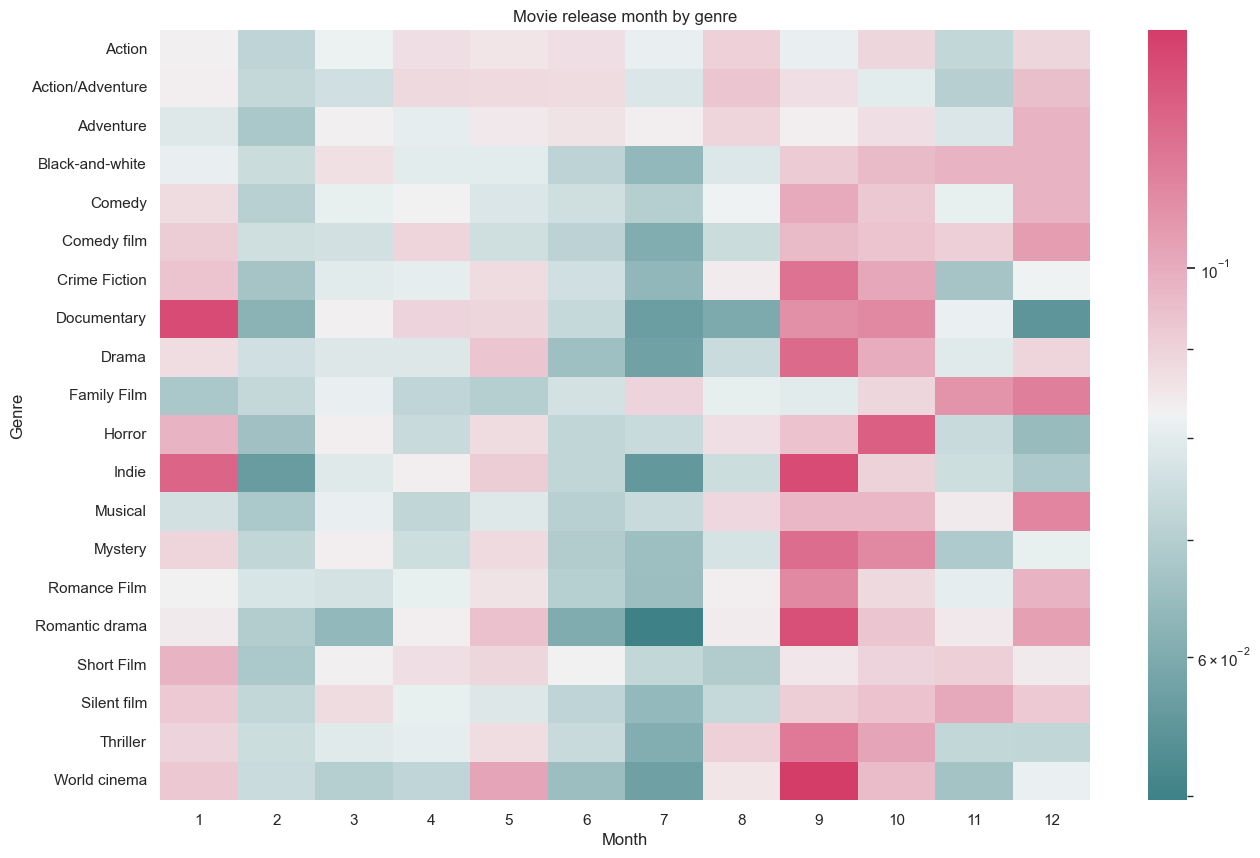

In [80]:
df_genre_month = pd.crosstab(df_movie_genre['Genre'],df_movie_genre['Month'])
normalized_df = pd.DataFrame(normalize(df_genre_month, axis=1, norm='l1'), index=df_genre_month.index, columns=df_genre_month.columns)

plt.subplots(figsize=(15, 10))
sbn.heatmap(normalized_df, annot=False, cmap=sbn.diverging_palette(200, 0, as_cmap=True), norm=LogNorm())
plt.title('Movie release month by genre')
plt.show()

The months of september and october seem having the most movies released, with the exceptions of Action and Action/Adventure genres who have month release dates more spread, with a small increase during the summer. In addition, we can see some genre that have still a good number of release during november and december, Comedy and Family Films for exemple, which could be explained with the arrival of the holidays of the end of the year. Other, otherwise, have a great reduction of release date during this date, like the Horror genre who is focused on september and october, certainly because of Halloween. The peak of september and october should however be analysed further to explain its existence.

Now let's look at the release year, of the genre, maybe we can see something else interesting too there.

Chisquare statistic : Power_divergenceResult(statistic=9634.004592422503, pvalue=0.0)


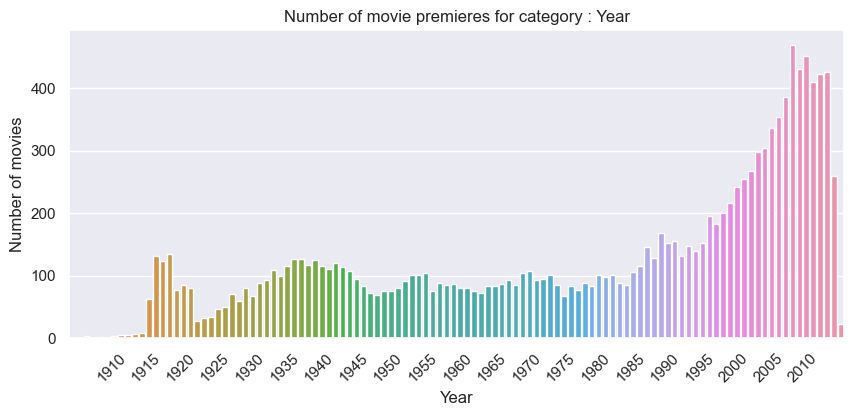

array([  1,   1,   3,   1,   2,   1,   4,   6,   6,   7,   8,  63, 132,
       123, 134,  77,  86,  81,  28,  32,  34,  47,  50,  71,  59,  81,
        67,  88,  93, 110, 100, 116, 127, 127, 117, 126, 115, 111, 121,
       114, 108,  95,  84,  73,  70,  75,  75,  80,  91, 102, 101, 104,
        75,  88,  86,  87,  80,  81,  76,  73,  83,  84,  87,  94,  86,
       104, 107,  93,  95, 102,  86,  68,  84,  78,  88,  83, 101,  98,
       101,  89,  85, 106, 115, 146, 128, 168, 153, 155, 132, 147, 140,
       152, 195, 182, 201, 216, 242, 254, 267, 298, 304, 336, 354, 386,
       469, 430, 451, 410, 422, 425, 259,  23])

In [81]:
#Let's take a genre with a great number of movie.
genre = 'Comedy'
genre_movie = df_movie_genre.groupby('Genre').get_group(genre)
count_var(genre_movie, 'Year')

It's seems at first glance that Comedy movie are becoming more popular as a increasing number of them are released. But this can be easily explained with the increased number of movie, regardless of genre.

Chisquare statistic : Power_divergenceResult(statistic=59777.53938260057, pvalue=0.0)


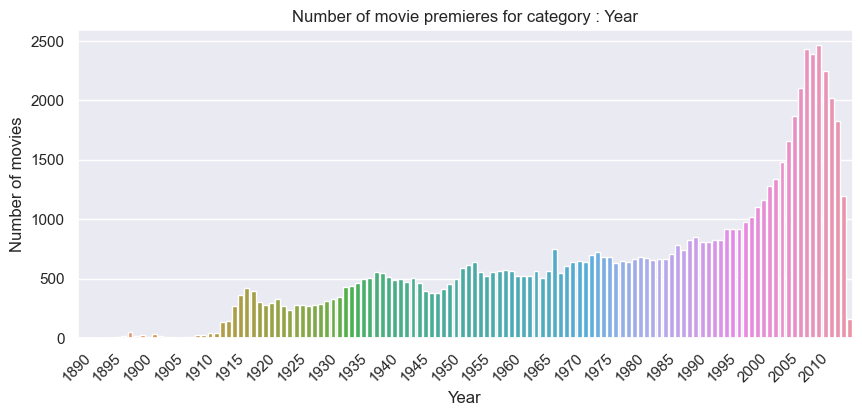

array([   1,    1,    2,    3,    3,    1,   10,   19,   54,   19,   26,
         12,   33,   23,    7,   13,    1,    9,   11,   24,   31,   41,
         44,  137,  146,  272,  366,  419,  401,  309,  282,  293,  327,
        273,  238,  278,  276,  272,  281,  292,  316,  331,  348,  429,
        442,  461,  501,  510,  558,  548,  518,  487,  498,  471,  505,
        464,  396,  385,  381,  412,  458,  496,  593,  619,  643,  558,
        521,  559,  570,  572,  563,  525,  527,  524,  562,  504,  567,
        751,  546,  604,  643,  648,  638,  703,  729,  686,  684,  632,
        654,  639,  665,  687,  679,  661,  669,  666,  709,  788,  739,
        825,  851,  810,  809,  827,  824,  915,  916,  915,  979, 1023,
       1100, 1163, 1280, 1340, 1480, 1662, 1872, 2102, 2435, 2390, 2466,
       2248, 2022, 1825, 1194,  165])

In [82]:
#Let's see with a count of every movie each year.
count_var(df_movie, 'Year')

This hypothesis seems correct. Thus, we need to normalize the data to have a better analysis.

Chisquare statistic : Power_divergenceResult(statistic=479.55892064908636, pvalue=5.6311708132184725e-43)


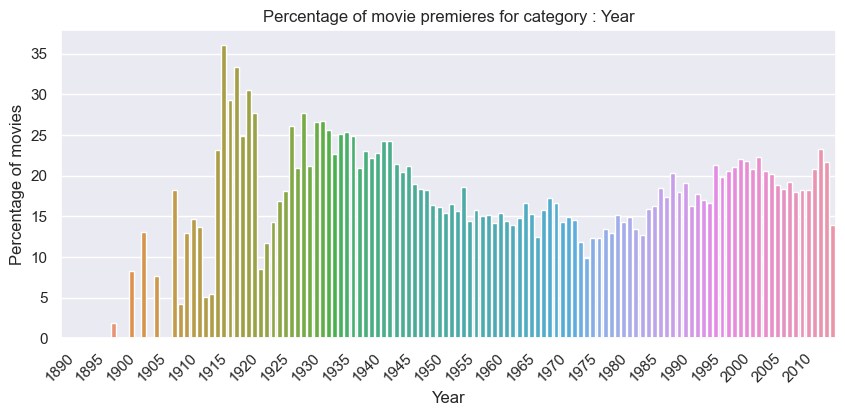

array([ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  1.85185185,  0.        ,
        0.        ,  8.33333333,  0.        , 13.04347826,  0.        ,
        7.69230769,  0.        ,  0.        , 18.18181818,  4.16666667,
       12.90322581, 14.63414634, 13.63636364,  5.10948905,  5.47945205,
       23.16176471, 36.06557377, 29.35560859, 33.41645885, 24.91909385,
       30.4964539 , 27.64505119,  8.56269113, 11.72161172, 14.28571429,
       16.90647482, 18.11594203, 26.10294118, 20.99644128, 27.73972603,
       21.20253165, 26.58610272, 26.72413793, 25.64102564, 22.62443439,
       25.1626898 , 25.3493014 , 24.90196078, 20.96774194, 22.99270073,
       22.2007722 , 22.7926078 , 24.29718876, 24.20382166, 21.38613861,
       20.47413793, 21.21212121, 18.96103896, 18.37270341, 18.2038835 ,
       16.37554585, 16.12903226, 15.34569983, 16.47819063, 15.70762053,
       18.63799283, 14.39539347, 15.74239714, 15.0877193 , 15.20

In [83]:
genre = 'Comedy'
genre_movie = df_movie_genre.groupby('Genre').get_group(genre)

count_var_normalized_genre(df_movie, genre_movie,'Year')

And now we will be able to analyse the data more precisely !

# 4. Analysis on release month and revenues 

## 4.0 Methology


-Can we find any trends in movie release dates within a year? Do these trends change across countries ? across history ?

We mainly use regression method to find whether there exists some relationship between 'release month' and 'Box office'.
The following is function we use:
$$Y = \beta_0 + \beta_1x_1 + \beta_2x_2 + ... + \beta_{11}x_{11}$$

$Y$ = Box office \
$X$ = Dummies variable of release month (Note: here we use December as bench mark)

In section 3.1 we regress box office on dummies varibles of release month for the whole data set. 

In section 3.2 we regress box office on dummies varibles of release month with respect to different countries. Note that in section 2, we only choose the countries with more than 200 datasets, because it will lack of accuracy due to insufficient samples.

In section 3.3, we regress box office on dummies variables of release month with respect to consecutive time periods (i.e. 1920-1940, 1940-1960, 1960-1980, 1980-2000, 2000-2012)


## 4.1 Regressing 'Box office' on 'month release'

### 4.1.1 Clean the data
1. Deep copy the df_movie data set
2. Drop 'nan' row for box office and Month columns.
3. Drop the row with 'Year' smaller than 1800.

In [84]:
# Group by "Freebase ID" and concatenate the strings in "Genre"
result_df = df_movie_genre.groupby('Freebase ID')['Genre'].agg(lambda x: ', '.join(x)).reset_index()
result_df
# Deep copy the data set
df_movie_month = df_movie.copy(deep=True)
df_movie_month = pd.merge(df_movie_month, result_df, on='Freebase ID', how='inner')
df_movie_month.dropna(subset = ['Box office','Month','Genre'], inplace = True)
df_movie_month = df_movie_month[['Box office','Countries (Freebase ID:name tuples)', 'Year', 'Month', 'Day' , 'Genre']]
month_release = pd.get_dummies(df_movie_month['Month'], prefix="Month")
month_release = month_release.iloc[:, :-1]
df_movie_month = pd.merge(df_movie_month, month_release, left_index=True, right_index=True)
df_movie_month['const'] = 1
df_movie_month

,Box office,Countries (Freebase ID:name tuples),Year,Month,Day,Genre,Month_1,Month_2,Month_3,Month_4,Month_5,Month_6,Month_7,Month_8,Month_9,Month_10,Month_11,const
0,14010832.0,"{""/m/09c7w0"": ""United States of America""}",2001,8,24,"Thriller, Action, Adventure, Horror",0,0,0,0,0,0,0,1,0,0,0,1
3,3600000.0,"{""/m/09c7w0"": ""United States of America""}",1938,8,16,"Comedy, Black-and-white, Musical",0,0,0,0,0,0,0,1,0,0,0,1
5,10161099.0,"{""/m/07ssc"": ""United Kingdom""}",1989,11,8,Drama,0,0,0,0,0,0,0,0,0,0,1,1
6,102272727.0,"{""/m/09c7w0"": ""United States of America""}",1964,8,27,"Drama, Comedy, Family Film, Musical",0,0,0,0,0,0,0,1,0,0,0,1
7,21521.0,"{""/m/09c7w0"": ""United States of America""}",1999,10,1,"Drama, Thriller, Indie",0,0,0,0,0,0,0,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44200,288752301.0,"{""/m/09c7w0"": ""United States of America""}",1988,6,29,"Drama, Comedy, Romance Film",0,0,0,0,0,1,0,0,0,0,0,1
44213,15369573.0,"{""/m/09c7w0"": ""United States of America""}",1990,4,27,"Comedy, Adventure, Family Film",0,0,0,1,0,0,0,0,0,0,0,1
44216,6944471.0,"{""/m/0f8l9c"": ""France"", ""/m/09c7w0"": ""United S...",2000,8,26,Comedy,0,0,0,0,0,0,0,1,0,0,0,1
44217,22886222.0,"{""/m/09c7w0"": ""United States of America""}",1993,6,4,"Drama, Thriller",0,0,0,0,0,1,0,0,0,0,0,1


### Country list

In [85]:
#get the list of names of the countries and store them into list_of_countries.
list_of_countries = get_list_of_countries(df_movie_month['Countries (Freebase ID:name tuples)'])
print(len(list_of_countries))
# Drop the name with direction (e.g west, south, east, north), except the countries like South Africa.

# Build up the ['South', 'North', 'West', 'East', 'south', 'north', 'west', 'east']
direction = ['South','North','West','East']
direction_2 = [x.lower() for x in direction]
di = direction + direction_2
display(di)

# To see which name of the courties contain ['South', 'North', 'West', 'East', 'south', 'north', 'west', 'east']
for i in list_of_countries:
    if any(substring in i for substring in di):
        print(i)
        
# Delete south korea and west germany
list_of_countries.remove('South Korea')
list_of_countries.remove('West Germany')

# We regress box office on dummies varibles of release month with respect to different countries. 
# Note that in section 2, we only choose the countries with more than 200 datasets.
countries = []
for country in list_of_countries:
    index_of_data = df_movie_month['Countries (Freebase ID:name tuples)'].str.contains(country)
    if index_of_data.sum() >= 200:
        countries.append(country)
        
        
countries.append('All 87 countries')
countries

87


['South', 'North', 'West', 'East', 'south', 'north', 'west', 'east']

West Germany
South Africa
South Korea


['Germany',
 'Canada',
 'United States of America',
 'France',
 'United Kingdom',
 'Korea',
 'All 87 countries']

### Gerne list

In [86]:
genre_list = df_movie_genre["Genre"].unique().tolist()
genre_list = genre_list + ['All genre']
genre_list

['Drama',
 'Comedy',
 'Romance Film',
 'Black-and-white',
 'Thriller',
 'Action',
 'Indie',
 'Crime Fiction',
 'World cinema',
 'Short Film',
 'Silent film',
 'Adventure',
 'Action/Adventure',
 'Horror',
 'Family Film',
 'Musical',
 'Romantic drama',
 'Documentary',
 'Mystery',
 'Comedy film',
 'All genre']

### Dynamic model

In [87]:
def plot_regression_month(df, country, year_range, match, genre):
    
    if match == 'match':
        pass
    # create month
    months = list(calendar.month_name)[1:]
    months = months[:-1]
    months.insert(0, 'const')
    
    # regression year selected
    start_year, end_year = year_range
    df = df[(df['Year'] >= start_year) & (df['Year'] <= end_year)]
    
    # regression country selected
    if country != "All 87 countries":
        df = df[df['Countries (Freebase ID:name tuples)'].str.contains(country)]
        
    # regression genre selected
    if genre != "All genre":
        df = df[df['Genre'].str.contains(genre)]
    
    
    
    months_list = ['const']+['Month_{}'.format(i) for i in range(1, 12)]

    
    model = sm.OLS(df['Box office'].values, df[months_list]).fit()
    dictionary = model.params, model.tvalues
    
    fig, ax = plt.subplots()

    ax.bar(months, dictionary[0])

    ax.set_xticks(range(len(months)))
    ax.set_xticklabels(months, rotation=45)
    ax.set_ylabel('coefficient')
    ax2 = ax.twinx()
    
    # Plot the t-values and 1.96 and -1.96 to check whether the coefficient is significant.
    ax2.plot(months, dictionary[1], color='orange', marker='o', label='t-values')
    ax2.plot(months, 12*[1.96], color='red', label='1.96')
    ax2.plot(months, 12*[-1.96], color='red', label='-1.96')
    ax2.set_ylabel('T-values')
    ax2.legend(loc='upper right')
    
    # Align the zero point for the left y-axis and right y-axis.
    aL, aaL = ax.get_ylim()
    aR, aaR = ax2.get_ylim()
    Left = ax.get_yticks()
    Right = ax2.get_yticks()
    aaL = max(aaL,abs(aL))
    aL = min(-aaL,aL)
    aaR = max(aaR,abs(aaR))
    aR = min(-aaR,aR)
    ax.set_ylim(aL,aaL)
    ax2.set_ylim(aR,aaR)
    ax.set_yticks(Left)
    ax2.set_yticks(Right)

    plt.tight_layout()
    plt.show()



def generate_html_output():
    year_range_widget = widgets.IntRangeSlider(value=[1914, 2020], min=df_movie_month['Year'].min(), max=df_movie_month['Year'].max(), step=1, description='Year Range:')
    country_widget = widgets.Dropdown(options=countries, value='United States of America', description='Country:')
    match_widget = widgets.Dropdown(options=['match','not match'], value='not match', description='Match:')
    genre_widget = widgets.Dropdown(options=genre_list, value='All genre', description='Genre:')

    output = widgets.interactive_output(plot_regression_month, {'df': widgets.fixed(df_movie_month), 'year_range': year_range_widget, 'country': country_widget, 'match': match_widget , 'genre':genre_widget})

    vbox_widget = widgets.VBox([year_range_widget, country_widget, genre_widget, match_widget, output])

    return vbox_widget

generate_html_output()

In this part, we're trying to figure out the ideal release date for movies that ensures the best performance at the box office. Our analysis covers data spanning from 1897 to 2012 across 87 countries.

Our primary method is regression analysis, examining if there's a connection between the 'release month' and the 'box office' performance. The formula we use is:
$$Y = \beta_0 + \beta_1x_1 + \beta_2x_2 + ... + \beta_{11}x_{11}$$

$Y$ = Box office \
$X$ = Dummies variable of release month (Note: here we use December as bench mark)

## Instructions of the dynamic model above
The value of blue bars is the coefficient value of $\beta_0,\beta_1,\beta_2,...\beta_{11}$, which is referred to the left-sided y-axis.\
The value of orange points is the t-value each of corresponding coefficient, which is referred to the right-sided y-axis.\
The value of red line (1.96) is used to check the significant of the coefficient under 95% confidence, which is referred to the right-sided y-axis. (e.g. if the t-value stay outside the interval [-1.96,1.96], then the corresponding coefficient is significant)

## Identifying the Best Month
After conducting regression for all 87 countries from 1897 to 2012, we observed that June consistently yields a significantly higher average Box Office compared to other months. This pattern persists when we perform the same analysis for countries with over 200 data points during the same period. However, the best month varies for specific countries; for the US and Germany, it's still June, but for the UK and France, it is July. Notably, the coefficients for Canada and Korea aren't significant, suggesting they don't offer valuable insights.
Our initial assumption is that June and July are generally the best release months for generating higher box office returns.

## Genre-Specific Analysis
We expand investigation to different genres while still using data from all 87 countries from 1897 to 2012, finding that most genres, such as Drama, Comedy, and Romance films, support our hypothesis that June and July are optimal release months. However, certain genres like Black-and-white films defy this trend, possibly due to their 'old school' nature, making them different from typical movies.



Then we try to find the best week during the month.



In [88]:
df_movie_week = new_date_format(df_movie_month)
months_list = ['Month_{}'.format(i) for i in range(1, 12)]
df_movie_week = df_movie_week.drop(columns=months_list )
week_release = pd.get_dummies(df_movie_week['Week_Number'])
week_release = week_release.iloc[:, :-1]
df_movie_week= pd.merge(df_movie_week, week_release, left_index=True, right_index=True)
df_movie_week

,Box office,Countries (Freebase ID:name tuples),Year,Month,Day,Genre,const,Release_Date,Week_Number,1,...,43,44,45,46,47,48,49,50,51,52
0,14010832.0,"{""/m/09c7w0"": ""United States of America""}",2001,8,24,"Thriller, Action, Adventure, Horror",1,2001-08-24,34,0,...,0,0,0,0,0,0,0,0,0,0
1,3600000.0,"{""/m/09c7w0"": ""United States of America""}",1938,8,16,"Comedy, Black-and-white, Musical",1,1938-08-16,33,0,...,0,0,0,0,0,0,0,0,0,0
2,10161099.0,"{""/m/07ssc"": ""United Kingdom""}",1989,11,8,Drama,1,1989-11-08,45,0,...,0,0,1,0,0,0,0,0,0,0
3,102272727.0,"{""/m/09c7w0"": ""United States of America""}",1964,8,27,"Drama, Comedy, Family Film, Musical",1,1964-08-27,35,0,...,0,0,0,0,0,0,0,0,0,0
4,21521.0,"{""/m/09c7w0"": ""United States of America""}",1999,10,1,"Drama, Thriller, Indie",1,1999-10-01,39,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7781,288752301.0,"{""/m/09c7w0"": ""United States of America""}",1988,6,29,"Drama, Comedy, Romance Film",1,1988-06-29,26,0,...,0,0,0,0,0,0,0,0,0,0
7782,15369573.0,"{""/m/09c7w0"": ""United States of America""}",1990,4,27,"Comedy, Adventure, Family Film",1,1990-04-27,17,0,...,0,0,0,0,0,0,0,0,0,0
7783,6944471.0,"{""/m/0f8l9c"": ""France"", ""/m/09c7w0"": ""United S...",2000,8,26,Comedy,1,2000-08-26,34,0,...,0,0,0,0,0,0,0,0,0,0
7784,22886222.0,"{""/m/09c7w0"": ""United States of America""}",1993,6,4,"Drama, Thriller",1,1993-06-04,22,0,...,0,0,0,0,0,0,0,0,0,0


In [89]:

def plot_regression_week(df, country, year_range, month_range, match, genre):
    
    if match == 'match':
        pass
    
    # create month
    num = ['const']
    num_2 = list(range(1, 53))
    weeks = num + num_2
    weeks_name = [str(item) for item in weeks]
    
    # regression year selected
    start_year, end_year = year_range
    df = df[(df['Year'] >= start_year) & (df['Year'] <= end_year)]
    
    # regression country selected
    if country != "All 87 countries":
        df = df[df['Countries (Freebase ID:name tuples)'].str.contains(country)]
    
        
    # regression month selected
    start_month, end_month = month_range
    df = df[(df['Month'] >= start_month) & (df['Month'] <= end_month)]
    
    
    # regression genre selected
    if genre != "All genre":
        df = df[df['Genre'].str.contains(genre)]
    
    
    model = sm.OLS(df['Box office'].values, df[weeks]).fit()
    dictionary = [model.params, model.tvalues]
    
    fig, ax = plt.subplots()

    ax.bar(weeks_name, dictionary[0])

    ax.set_xticks(range(len(weeks)))
    ax.set_xticklabels(weeks_name, rotation=60)
    ax.set_ylabel('coefficient')
    ax2 = ax.twinx()
    
    # Plot the t-values and 1.96 and -1.96 to check whether the coefficient is significant.
    ax2.plot(weeks_name, dictionary[1], color='orange', marker='o', label='t-values')
    ax2.plot(weeks_name, 53*[1.96], color='red', label='1.96')
    ax2.plot(weeks_name, 53*[-1.96], color='red', label='-1.96')
    ax2.set_ylabel('T-values')
    ax2.legend(loc='upper right')
    
    # Align the zero point for the left y-axis and right y-axis.
    aL, aaL = ax.get_ylim()
    aR, aaR = ax2.get_ylim()
    Left = ax.get_yticks()
    Right = ax2.get_yticks()
    aaL = max(aaL,abs(aL))
    aL = min(-aaL,aL)
    aaR = max(aaR,abs(aaR))
    aR = min(-aaR,aR)
    ax.set_ylim(aL,aaL)
    ax2.set_ylim(aR,aaR)
    ax.set_yticks(Left)
    ax2.set_yticks(Right)

    plt.tight_layout()
    plt.show()

# Create interactive widgets
year_range_widget = widgets.IntRangeSlider(value=[1914, 2020], min=df_movie_month['Year'].min(), max=df_movie_month['Year'].max(), step=1, description='Year Range:')
month_range_widget = widgets.IntRangeSlider(value=[6,7], min=df_movie_month['Month'].min(), max=df_movie_month['Month'].max(), step=1, description='Month Range:')
country_widget = widgets.Dropdown(options=countries, value='United States of America', description='Country:')
match_widget = widgets.Dropdown(options=['match','not match'], value='not match', description='Match:')
genre_widget = widgets.Dropdown(options=genre_list, value='All genre', description='Genre:')

# Create an interactive output widget
output = widgets.interactive_output(plot_regression_week, {'df': widgets.fixed(df_movie_week), 'year_range': year_range_widget,  'match': match_widget ,'country': country_widget, 'month_range': month_range_widget, 'genre':genre_widget})

# Display widgets
widgets.VBox([year_range_widget, month_range_widget, country_widget,genre_widget,match_widget,output])

### 4.1.2 Regressing box office on release month for all data. 
Note that we will store the coefficients and the corresponding t-values. And then we will visualize them on section 3.2

In [90]:
# Use w as a dictionary to store the coefficient.
w = {}

# Build up dependent varibale
movie_revenues = df_movie_month['Box office'].values

# Build up independent variable
month_release = pd.get_dummies(df_movie_month['Month']).values
# Remove one month column to select it as a baseline here December
month_release = month_release[:, :-1].astype(int)
month_release = sm.add_constant(month_release)

# Regress Box officie on release month for all data and store coefficient and and t-values
model = sm.OLS(movie_revenues, month_release).fit()
w['ALL'] = [model.params, model.tvalues]

In [91]:
#get the list of names of the countries and store them into list_of_countries.
list_of_countries = get_list_of_countries(df_movie_month['Countries (Freebase ID:name tuples)'])

# Drop the name with direction (e.g west, south, east, north), except the countries like South Africa.

# Build up the ['South', 'North', 'West', 'East', 'south', 'north', 'west', 'east']
direction = ['South','North','West','East']
direction_2 = [x.lower() for x in direction]
di = direction + direction_2
display(di)

# To see which name of the courties contain ['South', 'North', 'West', 'East', 'south', 'north', 'west', 'east']
for i in list_of_countries:
    if any(substring in i for substring in di):
        print(i)
        
# Delete south korea and west germany
list_of_countries.remove('South Korea')
list_of_countries.remove('West Germany')
len(list_of_countries)


['South', 'North', 'West', 'East', 'south', 'north', 'west', 'east']

West Germany
South Africa
South Korea


85

## 4.2 Regressing 'Box office' on 'month release' for different countries

### 4.2.1 Get the list of countries

In [92]:
#get the list of names of the countries and store them into list_of_countries.
list_of_countries = get_list_of_countries(df_movie_month['Countries (Freebase ID:name tuples)'])

# Drop the name with direction (e.g west, south, east, north), except the countries like South Africa.

# Build up the ['South', 'North', 'West', 'East', 'south', 'north', 'west', 'east']
direction = ['South','North','West','East']
direction_2 = [x.lower() for x in direction]
di = direction + direction_2
display(di)

# To see which name of the courties contain ['South', 'North', 'West', 'East', 'south', 'north', 'west', 'east']
for i in list_of_countries:
    if any(substring in i for substring in di):
        print(i)
        
# Delete south korea and west germany
list_of_countries.remove('South Korea')
list_of_countries.remove('West Germany')

['South', 'North', 'West', 'East', 'south', 'north', 'west', 'east']

West Germany
South Africa
South Korea


We can see South Korea and West Germany should be regarded as Korea and Germany, respectively. Then we delete "South Korea" and "West Germany" in the list_of_countries.

### 4.2.2 Regression for each countries

In [93]:
# We regress box office on dummies varibles of release month with respect to different countries. 
# Note that in section 2, we only choose the countries with more than 200 datasets.
for country in list_of_countries:
    index_of_data = df_movie_month['Countries (Freebase ID:name tuples)'].str.contains(country)
    if index_of_data.sum() >= 200:
        model = sm.OLS(df_movie_month[index_of_data]['Box office'].values, month_release[index_of_data,:]).fit()
        w[country] = [model.params, model.tvalues]

### 4.2.3 Visualize all the results

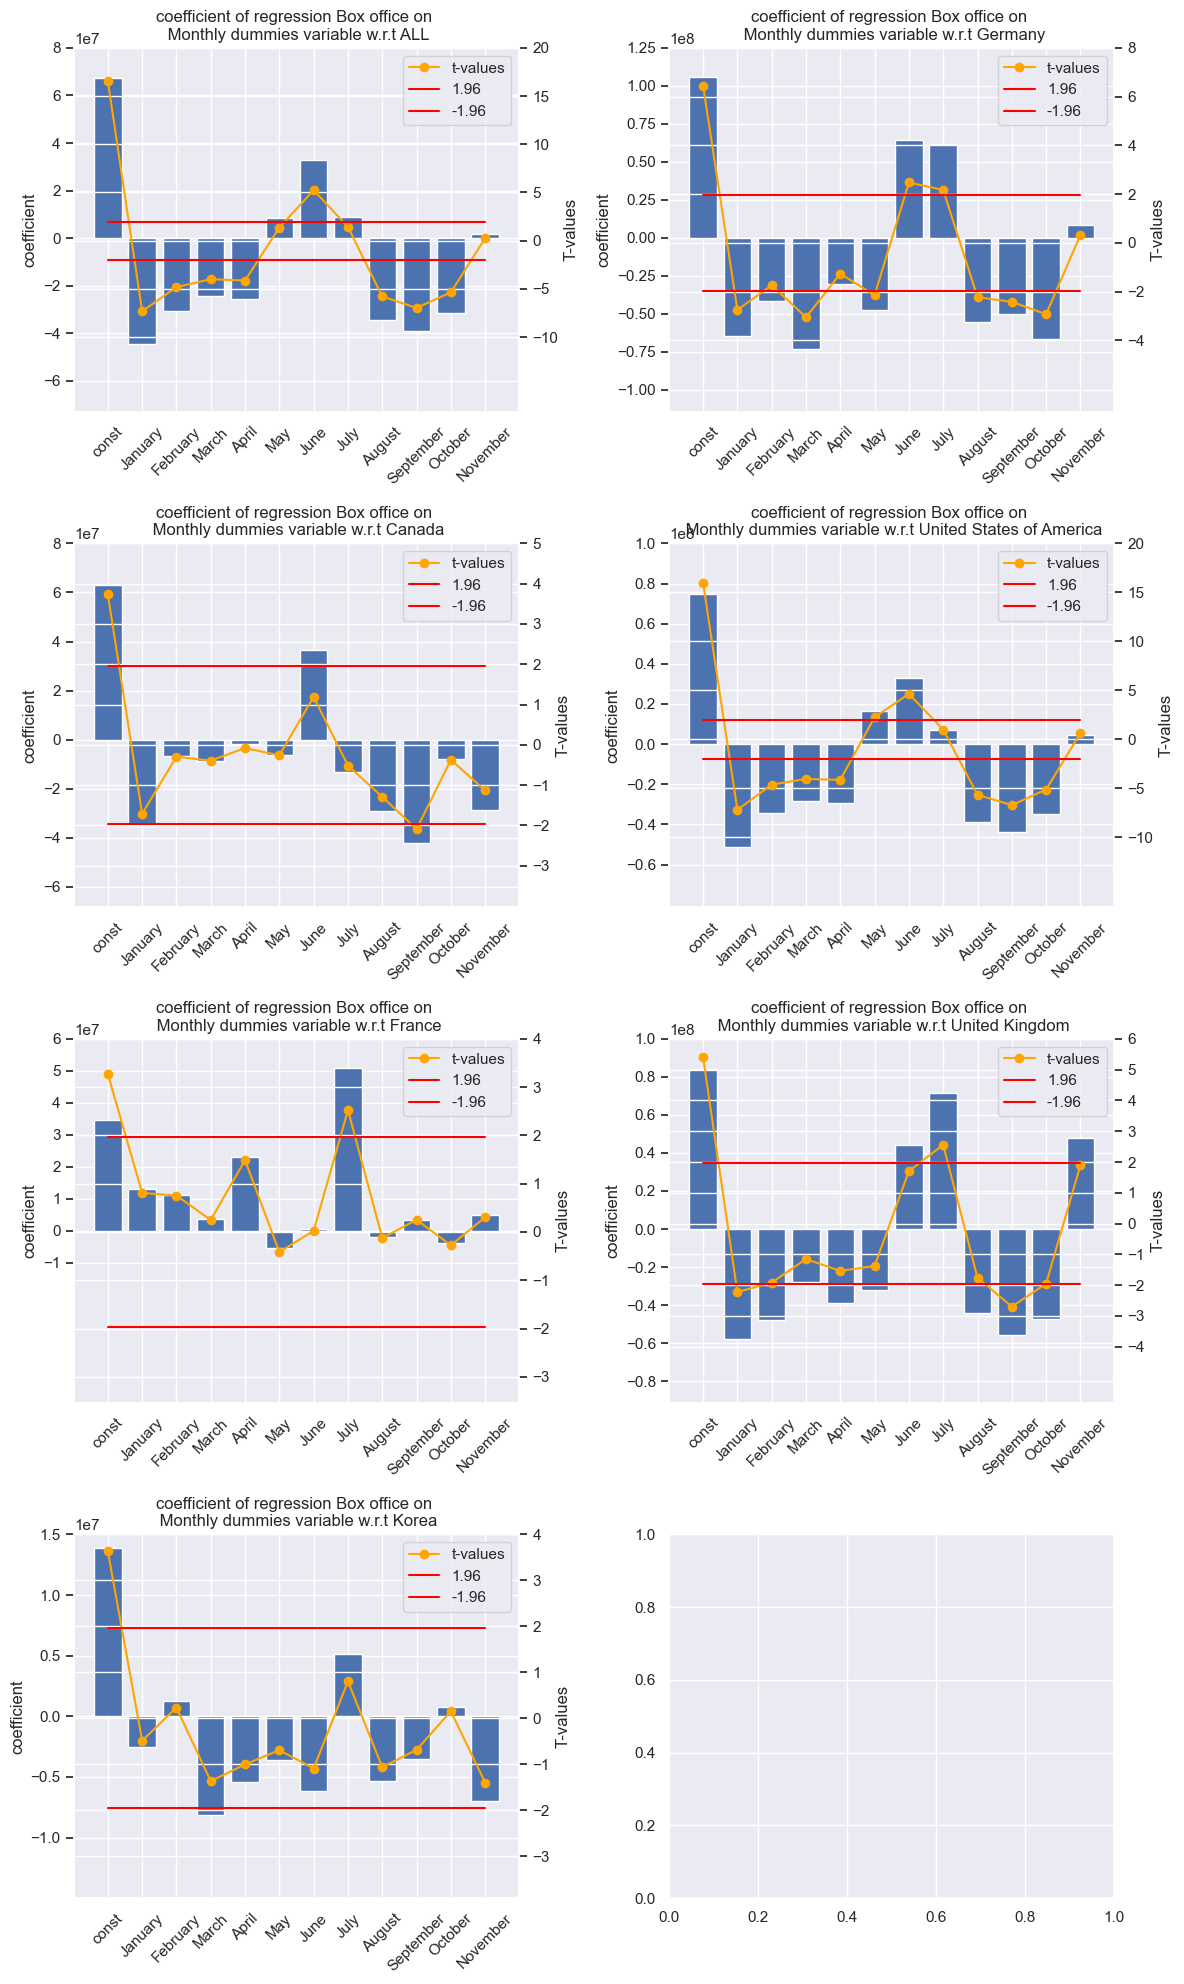

In [94]:
# Generate a list of month names
months = list(calendar.month_name)[1:]
months = months[:-1]
months.insert(0, 'const')

# Plot the regression of Box office on dummies variable of release month.
box_month_plot(4, 2, w, months, 12, 20)

### 4.2.4 What do we find?

Indeed, we find some trends. For overall data and the countries including the UK, US, Germany and France, it is significant that if the movie was released in July, it would have a higher average Box Office than that of the other month. But for Korea and Canada, the coefficient in July is insignificant, and we need to research why that happened. For the release date from January to May and August to October, almost all the countries have lower Box Officers than the benchmark (i.e. December's Box Office). It is worth noting that the average Box office in July is way higher than the other months in France. 

## 4.3 Regressing 'Box office' on 'month release' for each continuous 20-year time span.

In [95]:
# Take a look at the release year of the movies. 
np.sort(df_movie_month['Year'].unique())

array([1914, 1915, 1920, 1921, 1922, 1923, 1924, 1925, 1926, 1927, 1928,
       1929, 1930, 1931, 1932, 1933, 1934, 1935, 1936, 1937, 1938, 1939,
       1940, 1941, 1942, 1943, 1944, 1945, 1946, 1947, 1948, 1949, 1950,
       1951, 1952, 1953, 1954, 1955, 1956, 1957, 1958, 1959, 1960, 1961,
       1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970, 1971, 1972,
       1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983,
       1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994,
       1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005,
       2006, 2007, 2008, 2009, 2010, 2011, 2012], dtype=object)

### 4.3.1 Regression for each time interval

In [96]:
# Get the time interval
year_list = 1900 + np.arange(0,121,20)
year_list[0] = df_movie_month['Year'].min()

# Use w_over_twenty_year as a dictionary to store the coefficient
w_over_twenty_year = {}

# Regress box office on release month over the time interval
for i in np.arange(0,len(year_list)-1):
    df = df_movie_month [ (df_movie_month["Year"] >= year_list[i]).values and (df_movie_month["Year"] < year_list[i+1]).values]
    
    # Build up dependent variable (Box office) with respect to different time interval
    movie_revenues = df['Box office'].values
    
    # Build up independent variable (dummies varible of release month) with respect to different time interval
    month_release = pd.get_dummies(df['Month']).values
    month_release = month_release[:, :-1].astype(int)
    month_release = sm.add_constant(month_release)
    
    # Regress box office on release month over the time interval
    # And store the coefficients and corresponding t-values
    model = sm.OLS(movie_revenues, month_release).fit()
    w_over_twenty_year[year_list[i]] = [model.params, model.tvalues]


# Drop the time interval with coefficient less than 12.
store_name = []
for name in w_over_twenty_year.keys():
   if len(w_over_twenty_year[name][0]) < 12:
       store_name.append(name)
for name in store_name:
    del w_over_twenty_year[name]

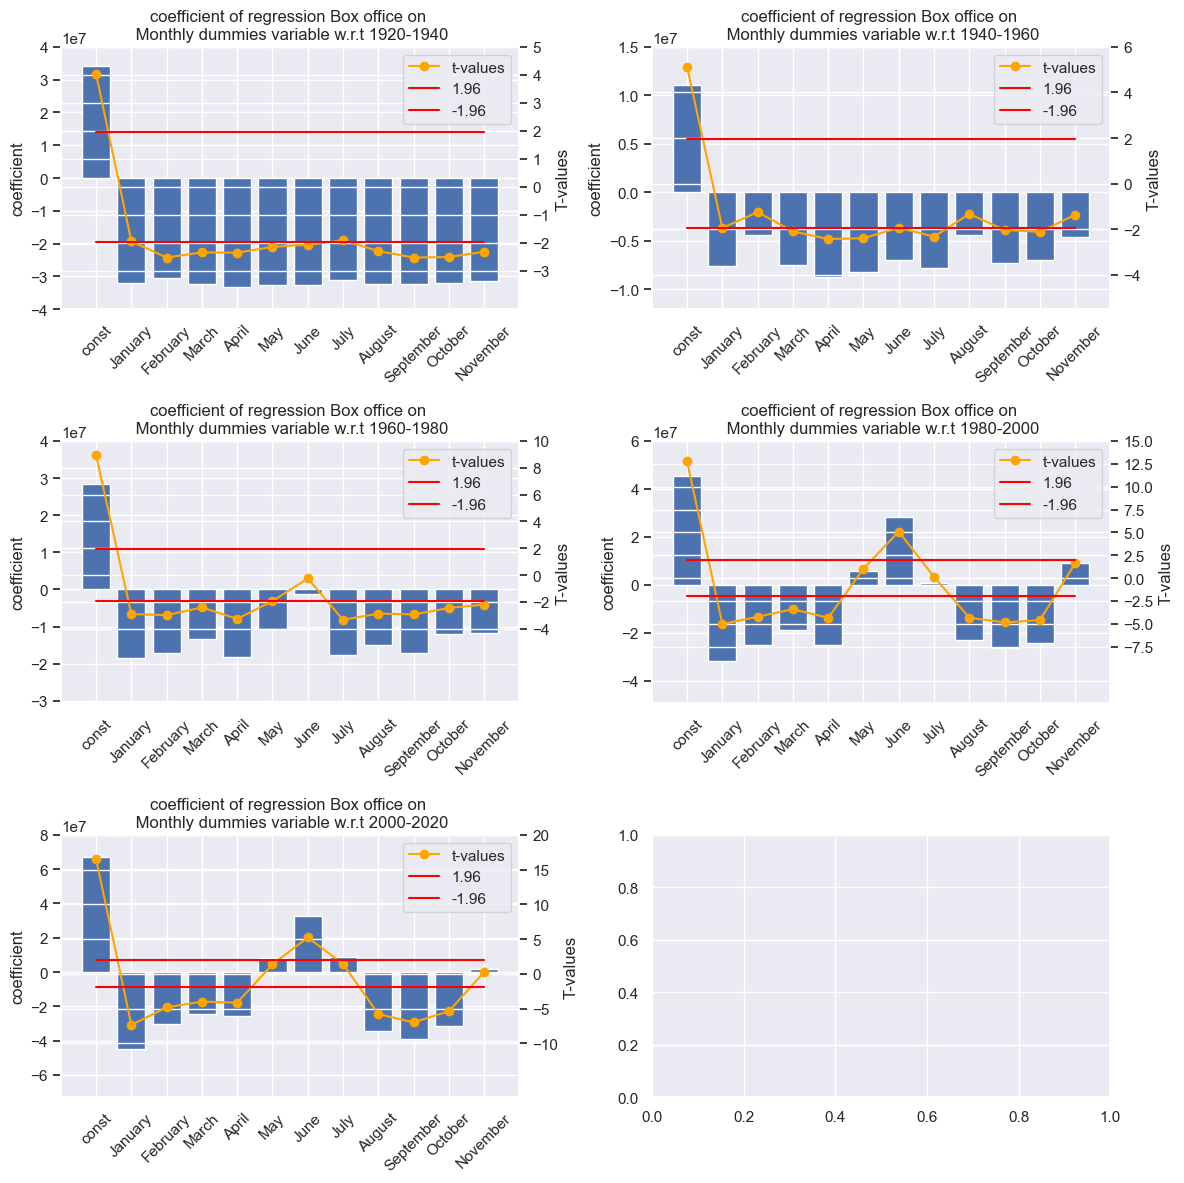

In [97]:
# Plot the regression of Box office on dummies variable of release month.
box_month_plot(3, 2, w_over_twenty_year, months, 12, 12)

### 4.3.2 What we find? and what we will do next?

We find it weird that if we release the movies in December, it would be higher than the other months, with an average rolling window of 20 years from 1920 to 1980. It would be interesting to go deeper into the weird situation.
The following step is to add some new independent variables like genre to see if the dummies variable of release month still significant. In other words, we need to add more independent variables to find the 'confounder'.

# 5. PCA anaysis 

Here is a first draft of the principal component analysis of our data.

In [98]:
#converting the year, month and day values into a datetime format and the week number of the release date
df_movie_PCA = new_date_format(df_movie)

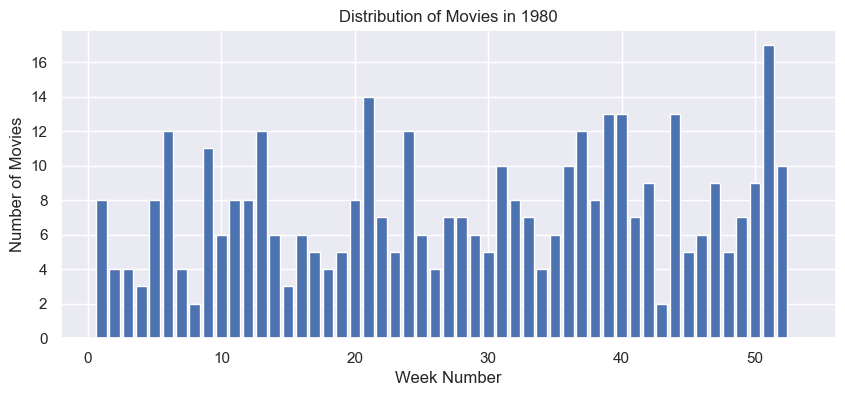

In [99]:
#count the number of movies coming out each week number each year 
movie_count_df = df_movie_PCA.groupby(['Year', 'Week_Number']).size().reset_index(name='Movie_Count')
#pivot the dataframe to create an array
movie_array = movie_count_df.pivot(index='Year', columns='Week_Number', values='Movie_Count').fillna(0).astype(int)
#select a subset of year to get more consistent results
movie_array = movie_array[(movie_array.index >= 1980) & (movie_array.index <= 2011)]
#change to observe other year
selected_year = 1980
#extract the row for the selected year
selected_year_row = movie_array.loc[selected_year]

#plot a histogram
plt.bar(selected_year_row.index, selected_year_row)
plt.xlabel('Week Number')
plt.ylabel('Number of Movies')
plt.title(f'Distribution of Movies in {selected_year}')
plt.show()

We look here at the number of movies coming out each week in 1980

<AxesSubplot:>

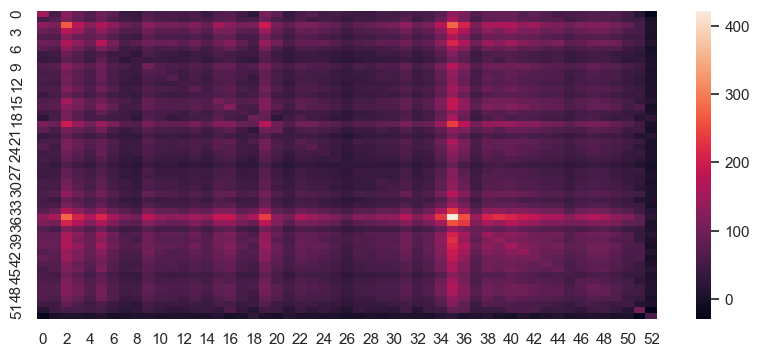

In [100]:
#computing the covariance matrix our our movies numbers across years
movie_array_val = movie_array.values
cov_matrix = np.cov(movie_array_val.T)
sbn.heatmap(cov_matrix)

The covariance matrix shows us the weeks of important common variance in movie releases

In [101]:
#computing the singular value decomposition
U, S, VT = np.linalg.svd(cov_matrix)
#choosing the number of components
nb_comp = 2
#taking the eigenvectors and eigenvalues
U_top = U[:, :nb_comp]
S_top = np.diag(S[:nb_comp])
VT_top = VT[:nb_comp, :]
#projecting our data on new coordinates
projected_data = np.dot(movie_array, U_top)
main_variations = np.dot(projected_data, U_top.T)

The Singular Value Decomposition is a standard decomposition techniques which gives us the eigenvectors and eigenvalues of our covariance matrix. These will be our principal components, ordered by variance explained. Then by projecting our original data on a certain number of components we get to see the points of common variance across years.

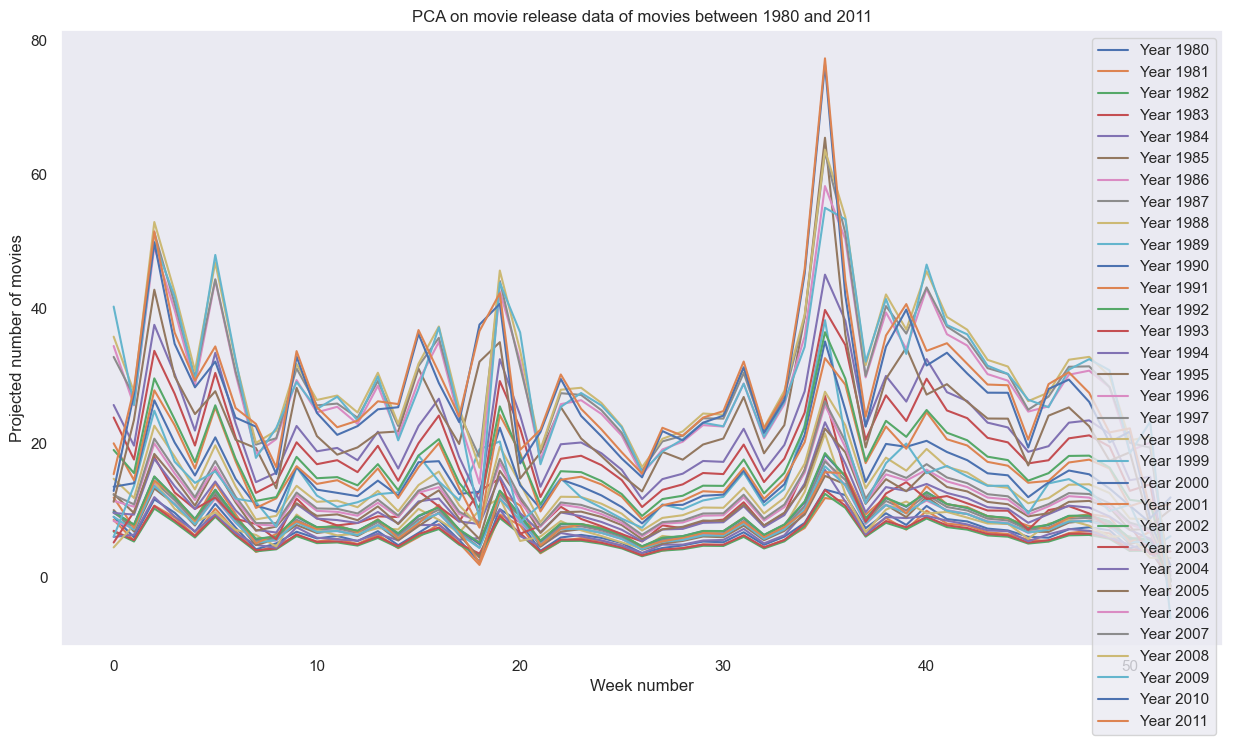

In [102]:
#plotting the PCA of our data projected onto two principal components
fig, ax = plt.subplots(figsize=(15, 8))
for i in range(32):
    ax.plot(main_variations[i], label=f'Year {i + 1980}')

ax.set_xlabel('Week number')
ax.set_ylabel('Projected number of movies')
ax.set_title('PCA on movie release data of movies between 1980 and 2011')
ax.legend()
ax.grid(which='both')
plt.show()

With further analysis, by looking at specific countries, genres and periods we'll be able to observe shared trends in movie releases that we could've missed otherwise.

# 6. Oscars analysis

We will now try to see if there is any correlation between movie release date within the year and its chances to win an oscar. To this end we will look at all the available oscar-winning movies and history and look at when in the year they've been released.

In [103]:
#extracting only the movies who won at least 1 oscar
only_winners = df_movie[(df_movie['num_oscars_won'] > 0)]
#using our function to get additionnal information
only_winners = new_date_format(only_winners)

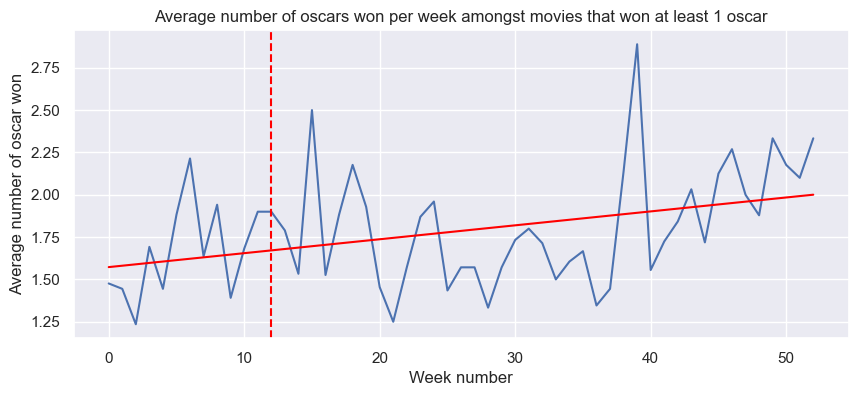

In [104]:
#looking at average number of oscars won by movies which came out each week
average_oscar_per_week = only_winners.groupby('Week_Number')['num_oscars_won'].mean()
average_oscar_per_week_array = average_oscar_per_week.values
weeks = np.arange(0,53)
#computing a linear regression to highlight particular trends
coefficients = np.polyfit(weeks, average_oscar_per_week_array, 1)
linear_fit = np.poly1d(coefficients)

plt.plot(average_oscar_per_week_array)
plt.axvline(x=12, color='red', linestyle='--', label='Oscar season begins')
plt.plot(weeks, linear_fit(weeks), color='red', label='Linear Regression')
plt.ylabel('Average number of oscar won')
plt.xlabel('Week number')
plt.title('Average number of oscars won per week amongst movies that won at least 1 oscar')
plt.show()

The blue plot represents the average number of oscars won by oscar-winning movies each week in the year. The red vertical dotted line shows the approximate moment the oscar season starts and the red line is a linear regression of the blue plot to try and observe significant trends. We would need further analysis to draw any conclusion but we could already hypothesize that the later in the year a movie comes out, the best are its chances to win an oscar, the reason why is still to be explored.